<a href="https://colab.research.google.com/github/ariG23498/RNN_Viz/blob/master/RNN_Keras_Viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports
The imports here are:
1. tensorflow
2. numpy
3. os
4. matplotlib

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# Data
1. https://cs.stanford.edu/people/karpathy/char-rnn/warpeace_input.txt - utf-8
2. https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt - latin-1

In [6]:
path_to_file = tf.keras.utils.get_file('linux.txt',
                                       'https://cs.stanford.edu/people/karpathy/char-rnn/linux_input.txt')
# Read, then decode for py2 compat.
# text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
text = open(path_to_file, 'rb').read().decode(encoding='latin-1')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 6206996 characters


## Observing
The text file has been read and we have obtained the whole text in string data type. Let us observe the first 250 letters of the text.

In [7]:
# Take a look at the first 250 characters in text
print(text[:250])

/*
 * linux/kernel/irq/autoprobe.c
 *
 * Copyright (C) 1992, 1998-2004 Linus Torvalds, Ingo Molnar
 *
 * This file contains the interrupt probing code and driver APIs.
 */

#include <linux/irq.h>
#include <linux/module.h>
#include <linux/interrupt.h>


Here we define the vocabulary of the text. Vocabulary is simply the unique elements in the text. This vocabulary will help us with the one-hot-encodings that is fed to the RNNs.

In [8]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

101 unique characters


Here we map the characters of the vocab to integer numbers, eg. `A->0, B->1`. This will help in transforming the alphabets to numbers. Numbers are easier to deal with in computer science.

We also want the other way round. Integers should be mapped to alphabets too, for the sake of simple retrieval of text.

After we are done with the mapping, we map the entire dataset to numbers.

In [9]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

The input text is of `3258227` characters. The data needs to be of `tf.data.Dataset` so that the input pipeline is smooth. We define a `seq_length` that holds the number of character that we would take in a sequence. This number represents the number of unfolds the RNN cell has to undergo in each iteration.

In [10]:
# The maximum length sentence we want for a single input in characters
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

for i in char_dataset.take(5):
  a = i.numpy()
  print('{} : {}'.format(a, idx2char[a]))

17 : /
12 : *
1 : 

2 :  
12 : *


In [11]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

Something that I learnt here is the use of `repr`. This spits out a string which can be evaluated. Here we can see that the carriage returns are replaced with `\n` and the escape sequences are well built too.

In [12]:
for item in sequences.take(5):
  print(repr(''.join(idx2char[item.numpy()])))

'/*\n * linux/kernel/irq/autoprobe.c\n *\n * Copyright (C) 1992, 1998-2004 Linus Torvalds, Ingo Molnar\n *'
'\n * This file contains the interrupt probing code and driver APIs.\n */\n\n#include <linux/irq.h>\n#inclu'
'de <linux/module.h>\n#include <linux/interrupt.h>\n#include <linux/delay.h>\n#include <linux/async.h>\n\n#'
'include "internals.h"\n\n/*\n * Autodetection depends on the fact that any interrupt that\n * comes in on'
' to an unassigned handler will get stuck with\n * "IRQS_WAITING" cleared and the interrupt disabled.\n '


## Creating the dataset
Here the batched sequences are mapped to extract the input and the target text. The inputs and the target text are offset by 1. This can be seen form the output.

In [13]:
def split_input_target(chunk):
  input_text = chunk[:-1]
  target_text = chunk[1:]
  return input_text, target_text

dataset = sequences.map(split_input_target)

for input_example, target_example in  dataset.take(1):
  print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
  print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  '/*\n * linux/kernel/irq/autoprobe.c\n *\n * Copyright (C) 1992, 1998-2004 Linus Torvalds, Ingo Molnar\n '
Target data: '*\n * linux/kernel/irq/autoprobe.c\n *\n * Copyright (C) 1992, 1998-2004 Linus Torvalds, Ingo Molnar\n *'


In this code snippet we try to get build batches of data. There are batches of 64 each containing 100 characters.

In [14]:
BATCH_SIZE = 64
BUFFER_SIZE = 10000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [15]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

# Model
The model is built with the following layers:
1. Embedding: This layer converts the interger input to a vector of `embedding_dim` dimensions.
2. LSTM: This is the Long Short Term Memory layer. This layer is representative of the LSTM cells. The parameter `return sequences` helps in returning all the hidden states of the LSTM. The parameter `stateful` means that the last state for each sample at index i in a batch will be used as initial state for the sample of index i in the following batch.
3. Dense: This layer projects the hidden state from the LSTM layer. This will be of the size of `vocab` so that we can apply a softmax to see what the next character is. 

In [16]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size,
                              embedding_dim,
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,
                        return_sequences=True,
                        stateful=True),
    tf.keras.layers.Dense(vocab_size)
  ])
  return model

In [17]:
tf.keras.backend.clear_session()

model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           25856     
_________________________________________________________________
lstm (LSTM)                  (64, None, 1024)          5246976   
_________________________________________________________________
dense (Dense)                (64, None, 101)           103525    
Total params: 5,376,357
Trainable params: 5,376,357
Non-trainable params: 0
_________________________________________________________________


In [19]:
def loss(labels, logits):
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

model.compile(optimizer='adam', loss=loss)

In [20]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [21]:
EPOCHS=20
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
960/960 [==============================] - 60s 62ms/step - loss: 1.8811
Epoch 2/20
960/960 [==============================] - 60s 62ms/step - loss: 1.1953
Epoch 3/20
960/960 [==============================] - 60s 62ms/step - loss: 1.0580
Epoch 4/20
960/960 [==============================] - 60s 63ms/step - loss: 0.9823
Epoch 5/20
960/960 [==============================] - 60s 62ms/step - loss: 0.9298
Epoch 6/20
960/960 [==============================] - 59s 62ms/step - loss: 0.8903
Epoch 7/20
960/960 [==============================] - 60s 63ms/step - loss: 0.8593
Epoch 8/20
960/960 [==============================] - 60s 63ms/step - loss: 0.8340
Epoch 9/20
960/960 [==============================] - 61s 63ms/step - loss: 0.8130
Epoch 10/20
960/960 [==============================] - 60s 63ms/step - loss: 0.7953
Epoch 11/20
960/960 [==============================] - 60s 63ms/step - loss: 0.7800
Epoch 12/20
960/960 [==============================] - 60s 63ms/step - loss: 0.7677
E

In [22]:
tf.train.latest_checkpoint(checkpoint_dir)

'./training_checkpoints/ckpt_20'

In [23]:
tf.keras.backend.clear_session()
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1)
# model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.load_weights('./training_checkpoints/ckpt_20')
model.build(tf.TensorShape([1, None]))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (1, None, 256)            25856     
_________________________________________________________________
lstm (LSTM)                  (1, None, 1024)           5246976   
_________________________________________________________________
dense (Dense)                (1, None, 101)            103525    
Total params: 5,376,357
Trainable params: 5,376,357
Non-trainable params: 0
_________________________________________________________________


In [24]:
intermediate_layer_model = tf.keras.models.Model(inputs=model.input,
                                                 outputs=model.get_layer('lstm').output)
intermediate_layer_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_input (InputLayer) [(1, None)]               0         
_________________________________________________________________
embedding (Embedding)        (1, None, 256)            25856     
_________________________________________________________________
lstm (LSTM)                  (1, None, 1024)           5246976   
Total params: 5,272,832
Trainable params: 5,272,832
Non-trainable params: 0
_________________________________________________________________


In [25]:
def generate_text(model, start_string, hidden_index):
  # Catch the hidden state
  h_list = []

  # Evaluation step (generating text using the learned model)

  # Number of characters to generate
  num_generate = 200

  # Converting our start string to numbers (vectorizing)
  input_eval = [char2idx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  # Empty string to store our results
  text_generated = []

  # Low temperatures results in more predictable text.
  # Higher temperatures results in more surprising text.
  # Experiment to find the best setting.
  temperature = 1.0

  # Here batch size == 1
  model.reset_states()
  for i in range(num_generate):
    predictions = model(input_eval)
    h = tf.squeeze(intermediate_layer_model(input_eval))
    h_list.append(h[hidden_index].numpy())
    # remove the batch dimension
    predictions = tf.squeeze(predictions, 0)

    # using a categorical distribution to predict the character returned by the model
    predictions = predictions / temperature
    predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

    # We pass the predicted character as the next input to the model
    # along with the previous hidden state
    input_eval = tf.expand_dims([predicted_id], 0)

    text_generated.append(idx2char[predicted_id])

  return (start_string + ''.join(text_generated)), h_list

In [66]:
from colorsys import hsv_to_rgb

def pseudocolor(val, minval, maxval):
  """ Convert val in range minval..maxval to the range 0..240 degrees which
      correspond to the colors Red and Green in the HSV colorspace.
  """
  h = (float(val-minval) / (maxval-minval)) * 120

  # Convert hsv color (h,1,1) to its rgb equivalent.
  # Note: hsv_to_rgb() function expects h to be in the range 0..1 not 0..360
  r, g, b = hsv_to_rgb(h/360, 1., 1.)
  return (r, g, b)

In [61]:
def draw_text(text, heat_map):
  fig, ax = plt.subplots()

  # text = '''Hey there, I am Aritra Roy Gosthipaty.
  # Nice to meet you'''
  # lol = np.random.rand(len(text))
  counter_x = 0.0
  counter_y = 1.0
  for ch, heat in zip(text,heat_map):
    if ch == '\n':
      counter_x = 0.0
      counter_y -= 0.1
      continue
    if ch == '\t':
      counter_x += 0.05
      continue
    ax.text(x = 0.+counter_x,
            y = 1.+counter_y,
            s = ch,
            color = 'black',
            fontweight = 'bold',
            fontsize=10,
            backgroundcolor = pseudocolor(heat, -1, 1)
            )
    counter_x += 0.05
  ax.axis('off')
  plt.show()

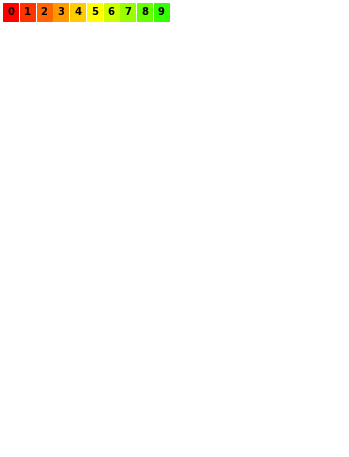

In [69]:
gen_text, h_list = '0123456789' ,[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8]
draw_text(gen_text, h_list)

In [75]:
gen_text, h_list = generate_text(model, start_string=u"#", hidden_index=420)
print(gen_text)

##Q##########f\n"


	if = 0,00008-1, wiler_fred prent *a;
	stact_ges(lockdb_gctint(flagemod" orlionse meriac,
		  of to bage ar_mobj_v;
ent_nablintaicmpt;

#unbloc/symol.
 */
	mon = 0600) {
	statt (__f


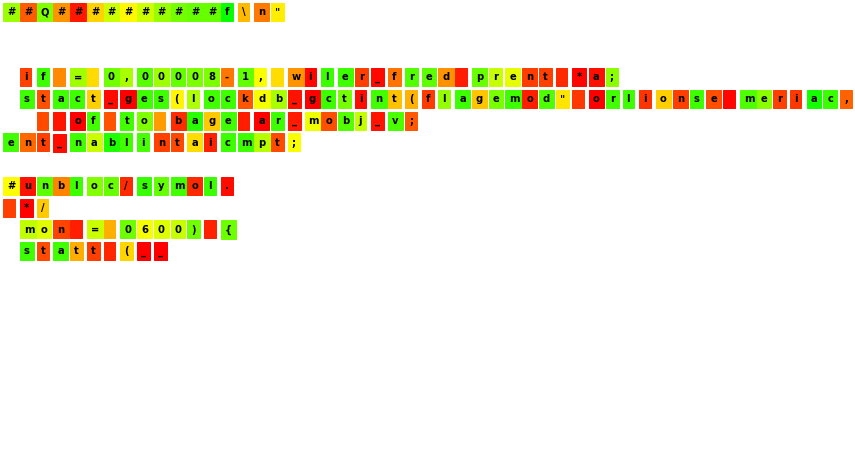

In [76]:
draw_text(gen_text, h_list)